In [ ]:
 # Pre-processing and modeling pipelines (ResNet50)
 # https://towardsdatascience.com/time-to-choose-tensorflow-data-over-imagedatagenerator-215e594f2435

 # Transfer learning with EfficientNet
 # https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

 # Image data input pipelines
 # https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5

In [ ]:
# Install additional packages

!pip install tf_keras_vis

     |████████████████████████████████| 53 kB 1.3 MB/s 


In [ ]:
import os
import pathlib
from glob import glob
import random
import time
import zipfile
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import time
from itertools import islice, count

from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.python.keras import backend as K
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD, Nadam, Adagrad, RMSprop
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.initializers import he_normal, glorot_normal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K # element-wise sigmoid
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency

from sklearn.model_selection import train_test_split

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Check which GPU is assigned to the session
!nvidia-smi

Sat Apr 23 17:34:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    33W / 250W |    377MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Ensure replicable results
import os
import random as rn
SEED = 109
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to Google Drive
google_drive_path = '/content/drive/My Drive/Colab Notebooks/CSCI_109b/cs109b_final_project/'

In [ ]:
# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print ('check shapes: ', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

170508288/170498071 [==============================] - 4s 0us/step
check shapes:  (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [ ]:
# Subset data
SUB_TRAIN = 2000
SUB_TEST = 500

X_train = X_train[:SUB_TRAIN,:,:,:]
y_train = y_train[:SUB_TRAIN,:]
X_test = X_test[:SUB_TEST,:,:,:]
y_test = y_test[:SUB_TEST,:]

In [ ]:
# One-hot encode targets
train_labels_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='uint8')

test_labels_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='uint8')

In [ ]:
# Test/Training split
train_images, val_images, train_labels, val_labels = train_test_split(X_train, 
                                                                      train_labels_categorical, 
                                                                      test_size=0.20, 
                                                                      stratify=train_labels_categorical, 
                                                                      random_state=123)

print ("train images shape: ", train_images.shape)
print ("validation images shape: ", val_images.shape)
print ("train labels shape: ", train_labels.shape)
print ("validation labels shape: ", val_labels.shape)

validation labels shape:  (400, 10)


In [ ]:
# Convert to TF data
training_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

validation_data = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

test_data = tf.data.Dataset.from_tensor_slices((X_test, test_labels_categorical))

print ("check types; '\n' ", type(training_data))
print (training_data.element_spec)

check types; '
'  <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(10,), dtype=tf.uint8, name=None))


In [ ]:
# Pre-processing layers

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation_layer = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

In [ ]:
# View example augmented images

class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
'dog', 'frog', 'horse', 'ship', 'truck'] # from cifar-10 website

# train_iter_5im, train_iter_5label = next(islice(training_data, 5, None)) # access the 5th element from the iterator

# train_iter_5im = tf.expand_dims(train_iter_5im, 0)
# train_iter_5label = train_iter_5label.numpy()

# plt.figure(figsize=(10, 10))

# for i in range(12):
#   plt.subplot(4, 3, i+1)
#   plt.xticks([])
#   plt.yticks([])
#   plt.grid(False)
#   aug_img = data_augmentation(train_iter_5im)
#   plt.imshow(aug_img[0], cmap='gray')
#   plt.xlabel(class_types [np.argmax(train_iter_5label)], fontsize=13)
# plt.tight_layout()    
# plt.show()

In [ ]:
# Set up batches

BATCH_SIZE_TRAIN = 32 # 128
BATCH_SIZE_VAL = 32

train_data_batches = training_data.shuffle(buffer_size=40000).batch(BATCH_SIZE_TRAIN).prefetch(buffer_size=AUTOTUNE)
val_data_batches = validation_data.batch(BATCH_SIZE_VAL).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Define model architecture

def create_model():
  base_model_layer = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
  # for layer in base_model.layers[:-30]:
  #   layer.trainable = False
  inputs = Input(shape=(32, 32, 3))
  rescale = rescale_layer(inputs)
  augmented = data_augmentation_layer(rescale)
  resnet = base_model_layer(augmented)
  pooling = GlobalAveragePooling2D()(resnet)
  dropout = Dropout(0.4)(pooling)
  outputs = Dense(len(class_types), activation='softmax')(dropout)
  # x = Activation(K.sigmoid)(outputs) # element-wise sigmoid
  model = Model(inputs=inputs, outputs=outputs)
  return model

clear_session()
base_model = create_model()
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [ ]:
# Callbacks

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min', 
    min_delta=0.1, 
    patience=10, 
    restore_best_weights=True, 
    verbose=True)

# Reduce learning rate by factor of 0.5 if val_coef_determination does not improve within 3 epochs
reduce_lrt_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    mode='min',
    min_delta=0.2,
    factor=0.5,
    patience=3, 
    min_lr=1e-6,
    verbose=2)

# This function keeps the initial learning rate for the first 7 epochs and decreases it exponentially after that
def scheduler(epoch, lr):
    if epoch <= 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lrt_scheduler = LearningRateScheduler(scheduler)

In [ ]:
# Compile

# Optimizers
opt = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile model
base_model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
# Train the model

# Parameters
EPOCHS = 50 

# Training
history = base_model.fit(
    x=train_data_batches,  
    validation_data=val_data_batches,
    epochs=EPOCHS,  
    verbose=1,
    use_multiprocessing=True, 
    callbacks=[early_stop, reduce_lrt_plateau, lrt_scheduler]
    )

%time

Epoch 1/50
50/50 [==============================] - 28s 109ms/step - loss: 3.4584 - accuracy: 0.1538 - val_loss: 348.2872 - val_accuracy: 0.0950 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 4s 81ms/step - loss: 3.0428 - accuracy: 0.1369 - val_loss: 6.0791 - val_accuracy: 0.1075 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 4s 82ms/step - loss: 2.8563 - accuracy: 0.1431 - val_loss: 2.9876 - val_accuracy: 0.1075 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 4s 81ms/step - loss: 2.8937 - accuracy: 0.1481 - val_loss: 2.6048 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - 4s 81ms/step - loss: 2.8414 - accuracy: 0.1600 - val_loss: 2.4057 - val_accuracy: 0.1025 - lr: 0.0010
Epoch 6/50
50/50 [==============================] - 4s 79ms/step - loss: 2.7848 - accuracy: 0.1619 - val_loss: 2.3131 - val_accuracy: 0.1100 - lr: 0.0010
Epoch 7/50
50/50 [==============================] - 4s 84ms/step - loss:

In [ ]:
# Save model

base_model.save(google_drive_path + 'output/base_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/CSCI_109b/cs109b_final_project/output/base_model/assets


In [ ]:
# Load model

base_model = load_model(google_drive_path + 'output/base_model')

In [ ]:
def plot_history(model, title:str=''):
    """Create plots for the training history"""
    
    h = model.history.history
    y1 = h['accuracy']
    y2 = h['val_accuracy']
    y3 = h['loss']
    y4 = h['val_loss']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

    x = model.history.epoch
    ax1.plot(x, y1, label='train', linewidth=2)
    ax1.plot(x, y2, label='validation', linewidth=2)
    ax1.set_title('Accuracy', fontsize=20)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    best_acc = np.nanmax(model.history.history['val_accuracy'])
    ax1.axvline(np.nanargmax(model.history.history['val_accuracy']),
                ls='--', label=f'best val acc = {best_acc:.2f}')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(x, y3, label='train', linewidth=2)
    ax2.plot(x, y4, label='validation', linewidth=2)
    ax2.set_title('Loss', fontsize=20)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    best_loss = np.nanmin(model.history.history['val_loss'])
    ax2.axvline(np.nanargmin(model.history.history['val_loss']),
                ls='--', label=f'best val loss = {best_loss:.2f}')
    ax2.grid(True)
    ax2.legend()

    fig.suptitle(title, fontsize=12)

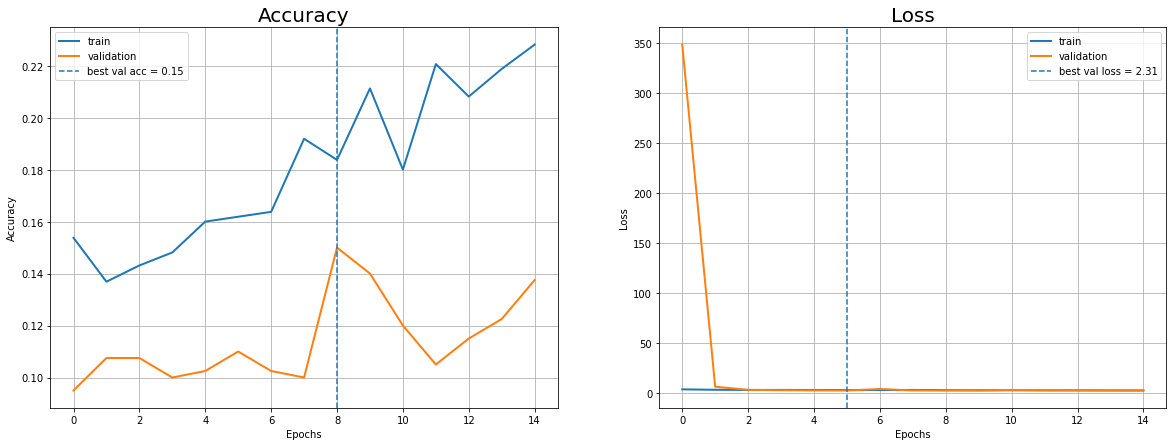

In [ ]:
# Plot training loss

plot_history(base_model)

In [ ]:
# Add functions for other performance metrics here


In [ ]:
# Add code for layer activation visualizations here
